# Ticket inspection AI

## Imports

In [193]:
import random
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle as pk

import optuna as opt
from sdv.tabular import GaussianCopula
from sdv.evaluation import evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, mean_squared_error

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Functions

In [194]:
def strCleaner(x: str) -> str:
    x = x.lower()
    x = x.replace(" ", "_")

    if "ja" in x:
        return "ja"

    return x


def clockTofloat(x: str) -> float:
    x = x[:-3]
    x = x.replace(":",".")
    x = float(x)
    return x

def extractHour(x):
    return x.hour

def extractMinute(x):
    return x.minute

def findCatCode(l, x: str) -> int:
    for i in range(len(l)):
        if l[i] == x:
            code = l.codes[i]
            return code
        
def datetimeToInt(dt) -> int:
    # second = dt.second
    minute = dt.minute*1
    hour = dt.hour*10
    day = dt.day*10000
    month = dt.month*1000000
    year = dt.year*100000000
    
    ret = minute+hour+day+month+year
    return ret

def extractDay(dt):
    return dt.day
    
def extractMonth(dt):
    return dt.month

def extractYear(dt):
    return dt.year

## Reading data

In [195]:
db = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data.xlsx")
#db = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data.xlsx')

db.head(2)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,L12,Fremst,2022-09-25,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,NaN
1,R10,Bakerst,2022-09-25,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,NaN


In [196]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     54 non-null     object        
 1   Vogn      54 non-null     object        
 2   Dato      54 non-null     datetime64[ns]
 3   Klokke    54 non-null     object        
 4   Fra       54 non-null     object        
 5   Til       54 non-null     object        
 6   Fullt?    54 non-null     object        
 7   Sjekket?  54 non-null     object        
 8   Merknad   4 non-null      object        
dtypes: datetime64[ns](1), object(8)
memory usage: 3.9+ KB


# Data cleaning and engineering

## Categorize the features

In [197]:
db["Fullt?"] = db["Fullt?"].apply(lambda x: strCleaner(x))
fulltCat = pd.Categorical(db["Fullt?"])
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes

db["Sjekket?"] = db["Sjekket?"].apply(lambda x: strCleaner(x))
sjekketCat = pd.Categorical(db["Sjekket?"])
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes

db["Linje"] = db["Linje"].apply(lambda x: strCleaner(x))
linjeCat = pd.Categorical(db["Linje"])
db["Linje"] = pd.Categorical(db["Linje"]).codes

db["Fra"] = db["Fra"].apply(lambda x: strCleaner(x))
fraCat = pd.Categorical(db["Fra"])
db["Fra"] = pd.Categorical(db["Fra"]).codes

db["Til"] = db["Til"].apply(lambda x: strCleaner(x))
tilCat = pd.Categorical(db["Til"])
db["Til"] = pd.Categorical(db["Til"]).codes

Vogn needs to be converted to a string

In [198]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: strCleaner(x))

vognCat = pd.Categorical(db["Vogn"])
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

Merknad needs to convert all empty values to -1

In [199]:
db["Merknad"].fillna(-1)

merknadCat = pd.Categorical(db["Merknad"])
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

In [200]:
fraCat

['eidsvoll', 'oslo_lufthavn', 'eidsvoll', 'nationaltheatret', 'eidsvoll', ..., 'nationaltheatret', 'eidsvoll', 'oslo_lufthavn', 'eidsvoll', 'oslo_lufthavn']
Length: 54
Categories (5, object): ['eidsvoll', 'nationaltheatret', 'oslo_lufthavn', 'oslo_s', 'skarnes']

Extract date sub-categories

In [201]:
# db['Dato'] = (db['Dato'] - db['Dato'].min())  / np.timedelta64(1,'D')
# db["Dato"] = db["Dato"].apply(lambda x: datetimeToInt(x))
# db["Dato"].head(3)

In [202]:
db["Dag"] = db["Dato"].apply(lambda x: extractDay(x))
db["Måned"] = db["Dato"].apply(lambda x: extractMonth(x))
# db["År"] = db["Dato"].apply(lambda x: extractYear(x)) # Not relevant for the timescale I have

db = db.drop("Dato", axis=1)
db.head(3)

,Linje,Vogn,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned
0,0,1,11:30:00,0,3,1,1,-1,25,9
1,2,0,21:59:00,2,0,0,0,-1,25,9
2,0,1,09:30:00,0,2,0,1,-1,26,9


Exctract time sub-categories

In [203]:
# db["Klokke"] = pd.Series(db["Klokke"], dtype="str")
# db["Klokke"] = db["Klokke"].apply(lambda x: clockTofloat(x))

In [204]:
db["Time"] = db["Klokke"].apply(lambda x: extractHour(x))
db["Minutt"] = db["Klokke"].apply(lambda x: extractMinute(x))

db = db.drop("Klokke", axis=1)
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,0,1,0,3,1,1,-1,25,9,11,30
1,2,0,2,0,0,0,-1,25,9,21,59
2,0,1,0,2,0,1,-1,26,9,9,30


In [205]:
# Vogn is just noise
db = db.drop("Vogn", axis=1)

In [206]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Linje     54 non-null     int8 
 1   Fra       54 non-null     int8 
 2   Til       54 non-null     int8 
 3   Fullt?    54 non-null     int8 
 4   Sjekket?  54 non-null     int8 
 5   Merknad   54 non-null     int8 
 6   Dag       54 non-null     int64
 7   Måned     54 non-null     int64
 8   Time      54 non-null     int64
 9   Minutt    54 non-null     int64
dtypes: int64(4), int8(6)
memory usage: 2.1 KB


<AxesSubplot: >

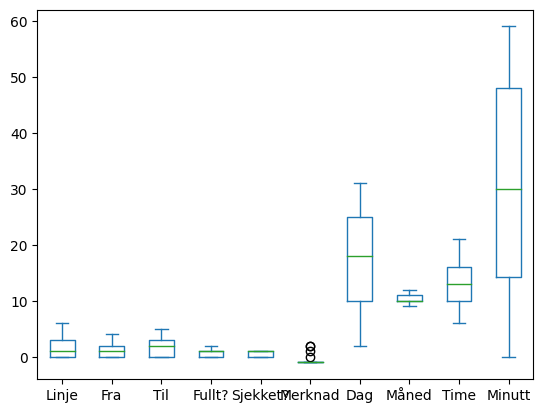

In [207]:
db.plot.box()

# Synthetic data

In [208]:
sdv = GaussianCopula()
sdv.fit(db)
sample = sdv.sample(250)
sample.head(3)

,Linje,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,5,1,1,0,0,-1,31,12,15,41
1,1,2,0,0,0,1,4,12,20,53
2,4,1,3,0,1,-1,25,10,7,16


In [209]:
# Dont work
evaluate(sample, db, metrics=['CSTest'], aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,None,None,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."


In [210]:
db = pd.concat([db, sample])

# Creating testing data

In [211]:
# Create the data to create predict from
X = db.drop(["Sjekket?"], axis=1)

# Create the data to predict to
y = db["Sjekket?"]

# Merknad has gives no impact on result
X = X.drop(["Merknad"], axis=1)

### Testing without clock
# X = X.drop(["Klokke"], axis=1)

X.head(3)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,0,0,3,1,25,9,11,30
1,2,2,0,0,25,9,21,59
2,0,0,2,0,26,9,9,30


# Train_test_split

In [212]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating model1 - XGBoostClassifier

In [213]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

[22:25:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [214]:
preds = model.predict(X_test)

## Model 1 testing

### Model 1's confusion matrix

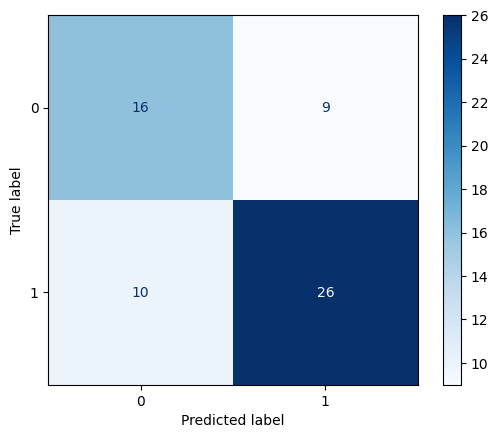

In [215]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

In [216]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
print(f"Accuracy: {accuracy * 100.0 : .2f}")

Accuracy:  68.85


### Model 1's feature importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

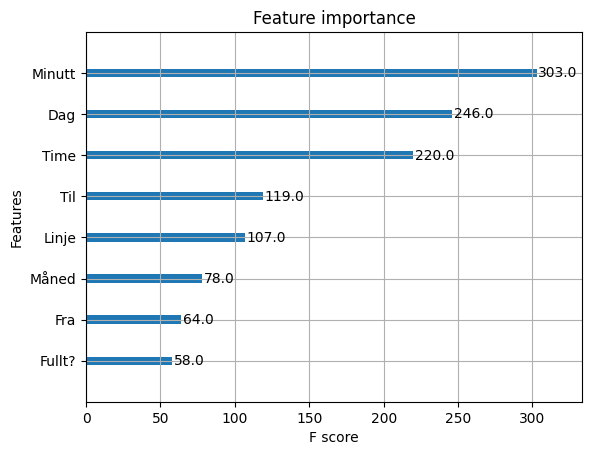

In [217]:
xgb.plot_importance(model)

# Creating model 2 - Model 1 with optuna

In [218]:
def objective(trial):
    """The objective is to find the best parameters for the most accuracy in the model"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e+3),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2023-01-05 22:25:44,925] A new study created in memory with name: no-name-db347944-df7f-4663-9929-907685b1205e
/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-01-05 22:25:44,977] Trial 0 finished with value: 0.5901639344262295 and parameters: {'max_depth': 3, 'learning_rate': 0.5401892718379124, 'n_estimators': 262, 'min_child_weight': 10, 'gamma': 0.0001282585213514294, 'subsample': 0.2836570881470133, 'colsample_bytree': 0.13396661655111688, 'reg_alpha': 0.09458532539418012, 'reg_lambda': 0.0006096458176316038}. Best is trial 0 with value: 0.5901639344262295.
/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas 

In [219]:
bparams = study.best_params
model2 = xgb.XGBClassifier(**bparams)
model2.fit(X_train, y_train)

/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:26:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.02064785208445782,
              enable_categorical=False, gamma=0.21270476637411675, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.04027072128967894, max_delta_step=0, max_depth=5,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=303, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=4.635491457176641e-07,
              reg_lambda=2.542925972340542e-05, scale_pos_weight=1,
              subsample=0.06639074727208832, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [220]:
preds2 = model2.predict(X_test)

## Model 2 testing

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

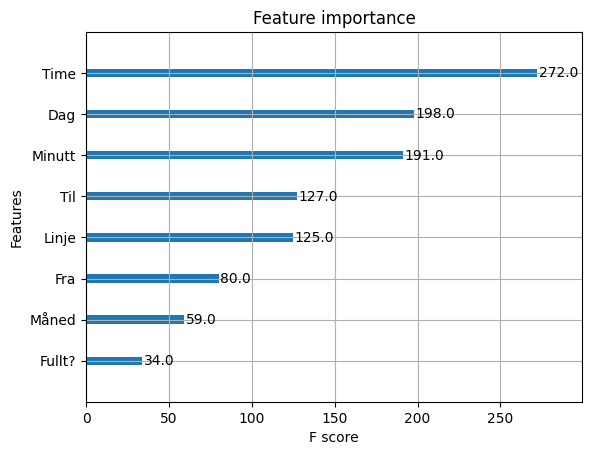

In [221]:
xgb.plot_importance(model2)

### Model 2 Confusion Matrix

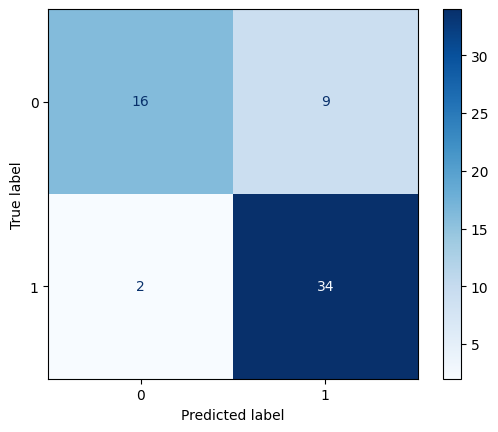

In [222]:
cm = confusion_matrix(y_true=y_test, y_pred=preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

In [223]:
accuracy2 = accuracy_score(y_true=y_test, y_pred=preds2)
print(f"Accuracy: {accuracy2 * 100.0 : .2f}")

Accuracy:  81.97


# Model 3 - Logistic regression

In [224]:
model3 = LogisticRegression(solver='liblinear', random_state=42)
model3.fit(X_train, y_train)
preds3 = model3.predict(X_test)


## Model 3 testing

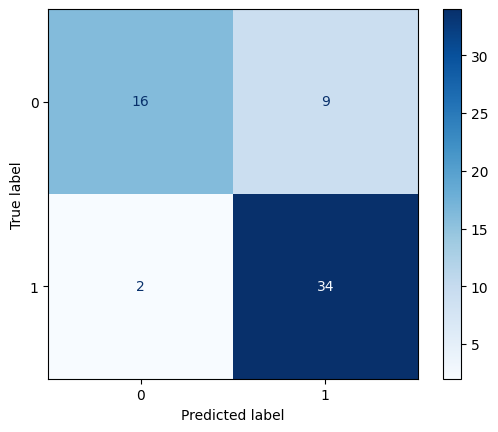

In [225]:
cm = confusion_matrix(y_true=y_test, y_pred=preds3)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)

disp.plot(cmap='Blues')

In [226]:
print(model3.score(X_test, y_test))
accuracy3 = accuracy_score(y_true=y_test, y_pred=preds3)
print(f"Accuracy: {accuracy3 * 100.0 : .2f}")

0.7377049180327869
Accuracy:  73.77


In [227]:
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.80      0.48      0.60        25
           1       0.72      0.92      0.80        36

    accuracy                           0.74        61
   macro avg       0.76      0.70      0.70        61
weighted avg       0.75      0.74      0.72        61



# Model 4 - Logistic regression with optuna

In [228]:
heyho = {'hello': 'hi'}

if 'hello' in heyho:
    index = list(heyho.values())[0]

print(index)

hi


In [229]:
def check_value_exist(dict: dict, liste: list) -> bool:
    do_exist = False
    for l in liste:
            for key, val in dict.items():
                if val == l:
                    do_exist = True
    return do_exist

In [230]:
def objective(trial):
    """
    Tests parameters for sciKit LogicalRegression
    """


    # Cant use suggest_categorical for multiple strings. Crashes
    # Tried with setting string values from random list number, dont work
    # CANT ACTUALLY SET STRING VALUES WIHTOUT USING CATEGORICAL, and that not workign with multiple
    # Solver
    # solver_num = random.randint(0, 4)
    # solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    solver = 'liblinear' # solver_list[solver_num]
    # fit_intercept
    # fit_num = trial.suggest_int('fit_num', 0, 1)

    params = {
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'C': trial.suggest_float('C', 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'random_state': trial.suggest_int('random_state', 0, 50),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0, 1.0),
        'solver': trial.suggest_categorical('solver', [solver]),
        'max_iter': trial.suggest_int('max_iter', 0, 60)
    }

    # Pentalty
    #if check_value_exist(params, ['newton-cg', 'lbfgs', 'sag']):
    #    number = random.randint(0, 1)
    #    if number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])})
    #elif check_value_exist(params, ['liblinear']):
    #number = random.randint(0, 1)
    #if number == 1:
    params.update({'penalty': trial.suggest_categorical('penalty', ["l1", "l2"])}) # l1 sucks with liblinear, dont use
    #else:
    #    params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #elif check_value_exist(params, ['saga']):
    #    number = random.randint(0, 3)
    #    if number == 0:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["elasticnet"])})
    #    elif number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    elif number == 2:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l1"])})  
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])}) 

    # l1_ratio //sucks balls man
    if check_value_exist(params, ['l1', 'elasticnet']):
        params.update({'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0)})

    # Dual
    if check_value_exist(params, ['l2']) and check_value_exist(params, ['liblinear']):
        params.update({'dual': trial.suggest_categorical('dual', [True, False])})
    #else:
    #    params.update({'dual': trial.suggest_categorical('dual', [False])})

    # Fit the model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

[I 2023-01-05 22:26:41,924] A new study created in memory with name: no-name-091cb106-5367-48c5-9a80-2b9ce4675c29
/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-01-05 22:26:41,930] Trial 0 finished with value: 0.7377049180327869 and parameters: {'tol': 0.041239098519063946, 'C': 0.5625889956003408, 'fit_intercept': True, 'random_state': 35, 'intercept_scaling': 0.6942709127465957, 'solver': 'liblinear', 'max_iter': 6, 'penalty': 'l2', 'dual': False}. Best is trial 0 with value: 0.7377049180327869.
/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-01-05 22:26:41,933] Trial 1 finished with value: 0.7049180327868853 and parameters: {'tol': 0.07275690384832478, 'C': 0.9266852711708389, 'f

In [231]:
bparams = study.best_params
model4 = LogisticRegression(**bparams)
model4.fit(X_train, y_train)
preds4 = model4.predict(X_test)
bparams

/opt/miniconda3/envs/billettkontroll/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'tol': 0.041239098519063946,
 'C': 0.5625889956003408,
 'fit_intercept': True,
 'random_state': 35,
 'intercept_scaling': 0.6942709127465957,
 'solver': 'liblinear',
 'max_iter': 6,
 'penalty': 'l2',
 'dual': False}

## Model 4 testing

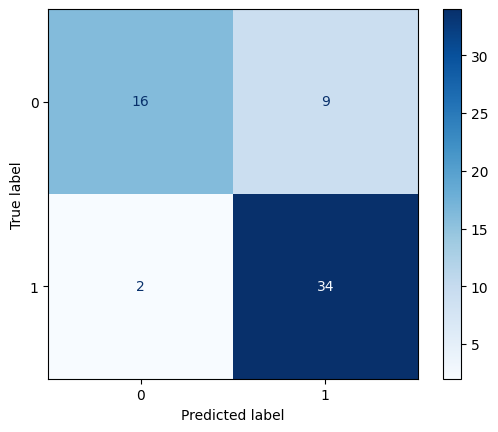

In [232]:
cm = confusion_matrix(y_true=y_test, y_pred=preds4)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)

disp.plot(cmap='Blues')

In [233]:
print(model4.score(X_test, y_test))
accuracy4 = accuracy_score(y_true=y_test, y_pred=preds4)
print(f"Accuracy: {accuracy4 * 100.0 : .2f}")

0.7377049180327869
Accuracy:  73.77


# Best

In [234]:
accuracies = [accuracy, accuracy2, accuracy3, accuracy4]

counter = 1
score = 0
for a in accuracies:
    if a > score:
        best = counter
        score = a
    
    counter = counter+1

print(f"Best is model number {best} with the score: {score * 100 : .2f}")

Best is model number 2 with the score:  81.97


In [235]:
if best == 1:
    bmodel = model
elif best == 2:
    bmodel = model2
elif best == 3:
    bmodel = model3
else:
    bmodel = model4

try:
    bmodel.save_model("../models/model.h5")
except:
    print("Can't save to H5 format.")

pk.dump(bmodel, open('../models/model.pkl', 'wb'))

In [236]:
pk.dump(X_test, open('../categories/X_test.pkl', 'wb'))

In [237]:
pk.dump(linjeCat, open('../categories/linjeCat.pkl', 'wb'))
pk.dump(vognCat, open('../categories/vognCat.pkl', 'wb'))
pk.dump(fraCat, open('../categories/fraCat.pkl', 'wb'))
pk.dump(tilCat, open('../categories/tilCat.pkl', 'wb'))
pk.dump(fulltCat, open('../categories/fulltCat.pkl', 'wb'))
pk.dump(sjekketCat, open('../categories/sjekketCat.pkl', 'wb'))

# Self testing

In [238]:
X_test.head(5)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
126,4,3,1,1,20,9,10,52
100,1,3,3,2,20,9,16,49
57,0,1,2,0,29,10,16,45
193,5,0,2,0,15,9,8,20
6,0,1,3,1,12,10,21,47


In [239]:
y_test.head(5)

126    1
100    1
57     1
193    0
6      1
Name: Sjekket?, dtype: int8

In [240]:
tester = X_test
tester = tester.drop(X_test.index)
tester

# Parameters
linje = "r11"
#vogn = "fremst"
fra = "nationaltheatret"
til = "eidsvoll"
fullt = "ja"
dag = 31
måned = 10
time = 14
minutt = 35

data = {"Linje": [findCatCode(linjeCat, linje)], 
          #"Vogn": [findCatCode(vognCat, vogn)],
          "Fra": [findCatCode(fraCat, fra)], 
          "Til": [findCatCode(tilCat, til)], 
         "Fullt?": [findCatCode(fulltCat, fullt)],
         "Dag": [dag],
         "Måned": [måned],
         "Time": [time],
         "Minutt": [minutt]}

testdb = pd.DataFrame(data)

tester = pd.concat([tester, testdb])
tester


,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,3,1,0,0,31,10,14,35


In [241]:
# Finds what the number means
ja = findCatCode(sjekketCat, 'ja')
nei = findCatCode(sjekketCat, 'nei')

print(f"{nei} = Nei\n"+
      f"{ja} = Ja")

testpred = bmodel.predict(tester)
print(f"Predicted: {testpred}")

if testpred[0] == ja:
    print("Ja, det er en sannsynlighet for å bli kontrollert")
else:
    print("Nei, det er liten sannsynlighet for å bli kontrollert")

1 = Nei
0 = Ja
Predicted: [0]
Ja, det er en sannsynlighet for å bli kontrollert


In [274]:
linjer = list(linjeCat.categories)
linjer

['l12', 'l14', 'r10', 'r11', 'r12', 're10', 're11']